In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import smtplib

from datetime import datetime
from email.message import EmailMessage
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
time_series = pd.read_excel("PositiveCase.xlsx")

In [3]:
time_series.head()

,Date,New_Positive
0,2020-03-02,2
1,2020-03-03,0
2,2020-03-04,0
3,2020-03-05,0
4,2020-03-06,2


In [4]:
time_series.index = pd.to_datetime(time_series['Date'])
time_series.drop(columns='Date',inplace=True)
time_series.head()

,New_Positive
Date,
2020-03-02,2
2020-03-03,0
2020-03-04,0
2020-03-05,0
2020-03-06,2


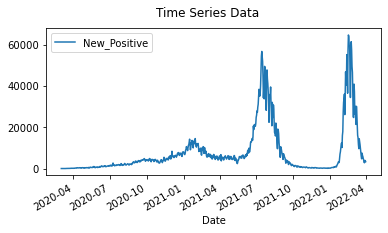

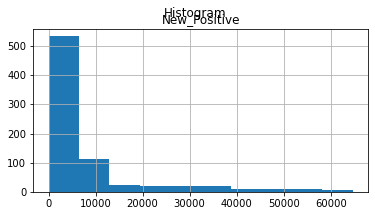

In [5]:
# Line plots of time series
fig, ax = plt.subplots(figsize=(6,3))
fig.suptitle('Time Series Data')
time_series.plot(ax=ax)
plt.show()
#Historgram
fig, ax = plt.subplots(figsize=(6,3))
fig.suptitle('Histogram')
time_series.hist(ax=ax)
plt.show()

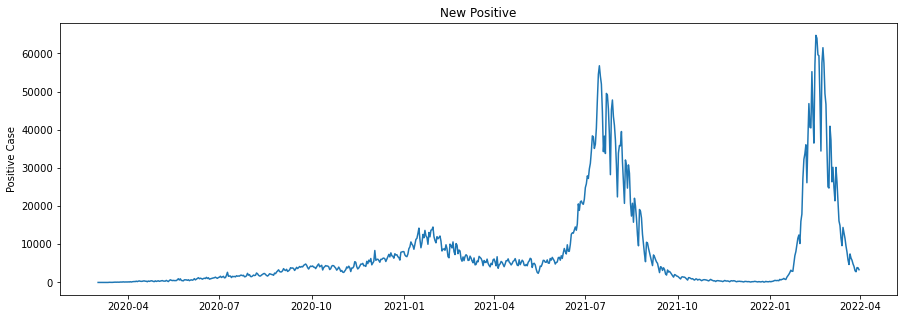

In [8]:
plt.figure(figsize=(15,5));
plt.plot(time_series.index,time_series['New_Positive']);
plt.ylabel('Positive Case');
plt.title('New Positive');
plt.plot();

In [64]:
decomp = seasonal_decompose(time_series, freq=12)
decomp.plot()
plt.show()

C:\Users\Bryan\AppData\Local\Temp/ipykernel_10624/2399096260.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  decomp = seasonal_decompose(time_series, freq=12)


TypeError: Index(...) must be called with a collection of some kind, 'seasonal' was passed

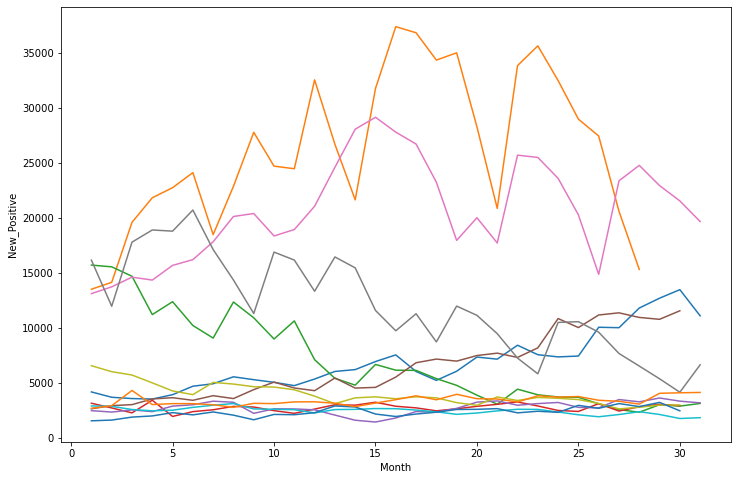

In [10]:
time_series['year'] = time_series.index.year
time_series['month'] = time_series.index.month
time_series['day'] = time_series.index.day
df_pivot = pd.pivot_table(time_series, values='New_Positive', index='day', columns='month', aggfunc='mean')
df_pivot.plot(figsize=(12,8))
plt.legend().remove()
plt.xlabel('Month')
plt.ylabel('New_Positive')
plt.show()

# Check for Stationarity

In [11]:
from statsmodels.tsa.stattools import adfuller
def adf_test(time_series):
     dftest = adfuller(time_series, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
adf_test(time_series['New_Positive'])

1. ADF :  -4.071800208842782
2. P-Value :  0.001077860315558779
3. Num Of Lags :  17
4. Num Of Observations Used For ADF Regression: 741
5. Critical Values :
	 1% :  -3.4392057325732104
	 5% :  -2.8654483492874236
	 10% :  -2.5688512291811225


If p< 0.05 ; Data is stationary
if p>0.05; Data is not stationary

    Because P-value< 0.05 Data is Stationary

In [42]:
# time_series.drop(['year'], axis=1, inplace=True)
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
# ax1 = plot_acf(time_series, lags=50, ax=ax1)
# ax2 = plot_pacf(time_series, lags=50, ax=ax2)
# plt.show()

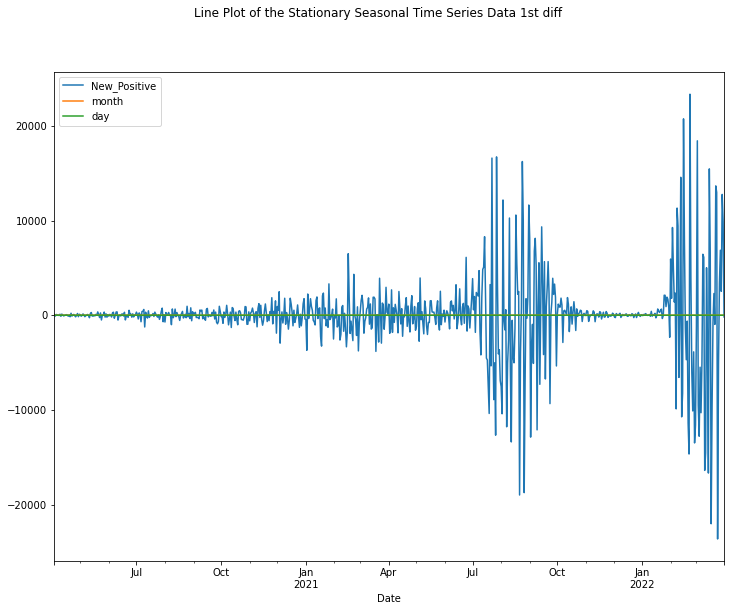

In [44]:
time_series_diff = time_series.diff().diff(30)
time_series_diff.dropna(inplace=True)

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Seasonal Time Series Data 1st diff')
time_series_diff.plot(ax=ax)
plt.show()

In [43]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(14,6), sharex=False, sharey=False)
# ax1 = plot_acf(time_series_diff, lags=50, ax=ax1)
# ax2 = plot_pacf(time_series_diff, lags=50, ax=ax2)
# plt.show()

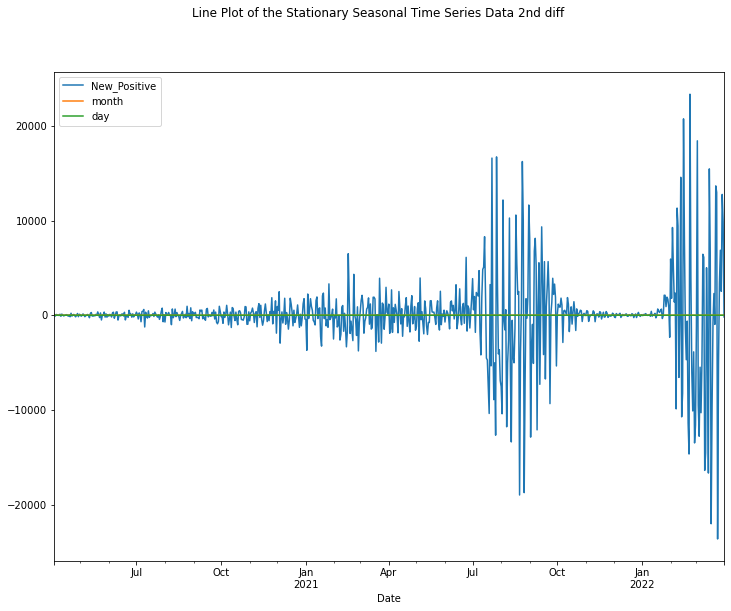

In [45]:
time_series_diff2 = time_series_diff.diff().diff(30)
time_series_diff2.dropna(inplace=True)

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Seasonal Time Series Data 2nd diff')
time_series_diff.plot(ax=ax)
plt.show()

In [16]:
result = adfuller(time_series["New_Positive"])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Test Statistics Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.071800
p-value: 0.001078
Critical Test Statistics Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [59]:
from pmdarima.arima import auto_arima
model = auto_arima(time_series['New_Positive'], d=1, D=1,seasonal=False, m=12, trend='c',start_p=0, start_q=0, max_order=12, test='adf', stepwise=True, trace=True)
print(model.summary())

C:\Users\Bryan\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (12) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14158.688, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14160.249, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14159.771, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14158.688, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=14141.686, Time=0.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14109.100, Time=0.13 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=14107.382, Time=0.04 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=14109.347, Time=0.07 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=14103.030, Time=0.30 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=14089.593, Time=0.18 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=14095.369, Time=0.07 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=14073.319, Time=0.20 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=14071.314, Time=0.13 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=14071.314, Time=0.12 sec

Best model:  ARIMA

<AxesSubplot:xlabel='Date'>

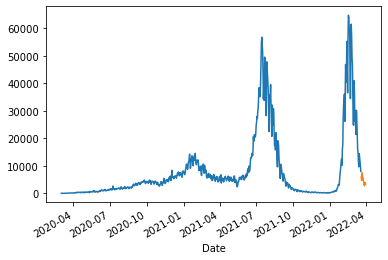

In [19]:
#divide into train and validation set
train = time_series.iloc[:len(time_series)-12]
test = time_series.iloc[len(time_series)-12:]

#plotting the data
train['New_Positive'].plot()
test['New_Positive'].plot()

In [56]:
models = SARIMAX(train['New_Positive'],order=(5,1,0))
results = models.fit()
print("Results of SARIMAX on train")
print(results.summary())

Results of SARIMAX on train
                               SARIMAX Results                                
Dep. Variable:           New_Positive   No. Observations:                  747
Model:               SARIMAX(5, 1, 0)   Log Likelihood               -6921.648
Date:                Tue, 19 Apr 2022   AIC                          13855.296
Time:                        09:05:01   BIC                          13882.984
Sample:                             0   HQIC                         13865.967
                                - 747                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0555      0.014     -3.839      0.000      -0.084      -0.027
ar.L2         -0.3038      0.016    -18.420      0.000      -0.336      -0.271
ar.L3         -0.0544   

C:\Users\Bryan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\Bryan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


C:\Users\Bryan\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


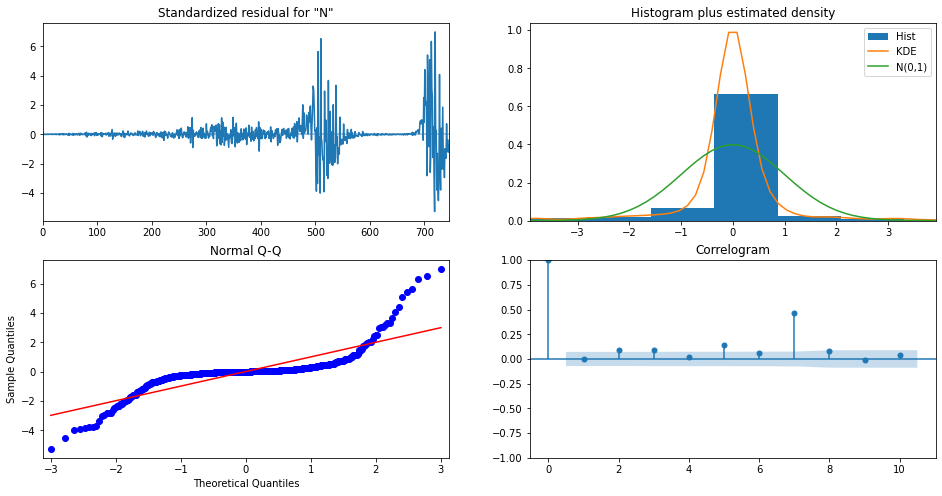

In [48]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

<AxesSubplot:xlabel='Date'>

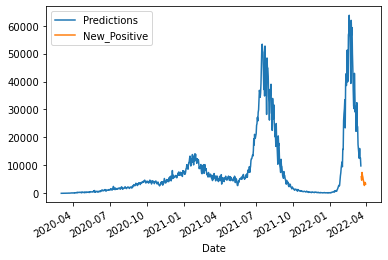

In [49]:
start = len(train)
end = len(train) + len(test) -1
  
# Predictions for one-year against the test set
predictions = results.predict(n_periods=len(test),exogenous=[],
                             typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True)
test['New_Positive'].plot(legend = True)

In [50]:
test["Forecast_ARIMAX"] = predictions

C:\Users\Bryan\AppData\Local\Temp/ipykernel_10624/3848346918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Forecast_ARIMAX"] = predictions


C:\Users\Bryan\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


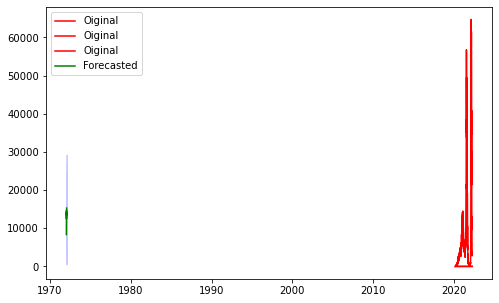

In [23]:
#Checking prediction value with test
forecast = results.get_forecast(steps=len(test))
mean = forecast.predicted_mean
conf_int = forecast.conf_int()
d = mean.index
plt.figure(figsize=(8,5))
# Plot past  levels
plt.plot(time_series.index, time_series, label='Oiginal', color = 'red')
# Prediction Mean
plt.plot(d, mean, label='Forecasted', color= 'green')
# Shade of space between  confidence intervals
plt.fill_between(d, conf_int.iloc[:,0], conf_int.iloc[:,1],
alpha=0.2, color= 'blue')
# Plot legend 
plt.legend()
plt.savefig('p')
plt.show()


In [34]:

test["Forecast_ARIMAX"] = results

C:\Users\Bryan\AppData\Local\Temp/ipykernel_10624/481978565.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Forecast_ARIMAX"] = results


<AxesSubplot:xlabel='Date'>

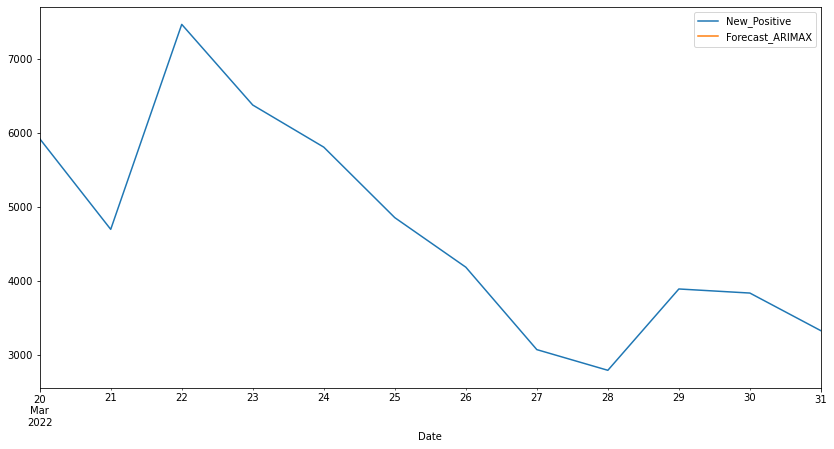

In [51]:
test[["New_Positive", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

# ARIMA

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(data['New_Positive'].dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig1=plot_acf(data['New_Positive'].dropna())
fig2=plot_pacf(data['New_Positive'].dropna())

In [ ]:
time_series_diff = data.diff().diff(30)
time_series_diff.dropna(inplace=True)

# Plot differenced data
fig, ax = plt.subplots(figsize=(12,9))
fig.suptitle('Line Plot of the Stationary Seasonal Time Series Data')
time_series_diff.plot(ax=ax)
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(time_series_diff.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig1=plot_acf(time_series_diff['New_Positive'].dropna())
fig2=plot_pacf(time_series_diff['New_Positive'].dropna())

In [ ]:
from pmdarima.arima import auto_arima
model = auto_arima(data['New_Positive'], d=1, D=1,seasonal=True, m=30, trend='c',start_p=0, start_q=0, max_order=6, test='adf', stepwise=True, trace=True)
print(model.summary())

In [ ]:
train = data[:int(0.85*(len(data)))]
test = data[int(0.85*(len(data))):]

#plotting the data
train['New_Positive'].plot()
test['New_Positive'].plot()

In [ ]:
model = SARIMAX(train['New_Positive'],order=(2,1,0),seasonal_order=(2,1,0,30))
results = model.fit()
print("Results of SARIMAX on train")
print(results.summary())

In [ ]:
results.plot_diagnostics(figsize=(16, 8))
plt.savefig('modeldiagnostics')
plt.show()

In [ ]:
model = SARIMAX(train['New_Positive'],order=(2,1,0),seasonal_order=(2,1,0,30))
results = model.fit()
print("Results of SARIMAX on train")
print(results.summary())
test["Forecast_ARIMAX"] =forecast

In [ ]:
from pmdarima.arima import auto_arima
model = auto_arima(train.New_Positive, exogenous=train[exogenous_features],trace=True, error_action="ignore", suppress_warnings=True)
model.fit(train.New_Positive, exogenous=train[exogenous_features])

In [ ]:
# forecast = results.get_forecast(steps=len(test))
forecast = model.predict(n_periods=len(test),exog=None,order=(2,1,0),seasonal_order=(2,1,0,30))

In [ ]:
test[["New_Positive", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [ ]:
# #Checking prediction value with test
# forecast = results.get_forecast(steps=len(test))
# mean = forecast.predicted_mean
# conf_int = forecast.conf_int()
# d = mean.index
# plt.figure(figsize=(12,10))
# # Plot past  levels
# plt.plot(data.index, data, label='Oiginal', color = 'red')
# # Prediction Mean
# plt.plot(d, mean, label='Forecasted', color= 'green')
# # Shade of space between  confidence intervals
# plt.fill_between(d, conf_int.iloc[:,0], conf_int.iloc[:,1],alpha=0.2, color= 'blue')
# # Plot legend 
# plt.legend()
# plt.savefig('p')
# plt.show()

In [ ]:
# from sklearn.metrics import r2_score
# print('R2score is',r2_score(test['New_Positive'], predictions))
# mean_absolute_percentage_error = np.mean(np.abs(predictions - test['New_Positive'])/np.abs(test['New_Positive']))*100
# print('MAPE is', mean_absolute_percentage_error)

autocorelation plot

In [ ]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(6, 2, sharex=True)
axes[0, 0].plot(data['New_Positive']); axes[0, 0].set_title('Original Series')
plot_acf(data['New_Positive'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(data['New_Positive'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(data['New_Positive'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(data['New_Positive'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(data['New_Positive'].diff().diff().dropna(), ax=axes[2, 1])
# 3rd Differencing
axes[3, 0].plot(data['New_Positive'].diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(data['New_Positive'].diff().diff().dropna(), ax=axes[3, 1])
# 4th Differencing
axes[4, 0].plot(data['New_Positive'].diff().diff()); axes[4, 0].set_title('4th Order Differencing')
plot_acf(data['New_Positive'].diff().diff().dropna(), ax=axes[4, 1])
# 5th Differencing
axes[5, 0].plot(data['New_Positive'].diff().diff()); axes[5, 0].set_title('5th Order Differencing')
plot_acf(data['New_Positive'].diff().diff().dropna(), ax=axes[5, 1])

plt.show()

In [ ]:
exogenous_features = [
       'Flag_Varian','Total_kasus','Sembuh','Meninggal_Dunia'
    ]

# Training and Testing

In [ ]:
# data.drop(columns='Flag Varian',inplace=True)

In [ ]:
train=data.iloc[:-152]
test=data.iloc[-152:]
print(train.shape,test.shape)

In [ ]:
test

# ARIMAX

In [ ]:
# model = auto_arima(train.New_Positive, exogenous=train.Flag_Varian.values.reshape(-1, 1), trace=True, error_action="ignore", suppress_warnings=True)
# model.fit(train.New_Positive, exogenous=train.Flag_Varian.values.reshape(-1, 1),order=(5,1,5))

In [ ]:
from pmdarima.arima import auto_arima
model = auto_arima(train.New_Positive, exogenous=train[exogenous_features],trace=True, error_action="ignore", suppress_warnings=True)
model.fit(train.New_Positive, exogenous=train[exogenous_features])

In [ ]:
forecast = model.predict(n_periods=len(test), exogenous=test[exogenous_features],order=(4,1,5))
test["Forecast_ARIMAX"] = forecast

In [ ]:
test[["New_Positive", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [ ]:
import pmdarima as pmd
def arimamodel(timeseriesarray):
    autoarima_model=pmd.auto_arima(timeseriesarray,
                                   start_p=1,
                                   start_q=1,
                                   test="adf",
                                   trace=True)
    return autoarima_model

In [ ]:
arima_model = arimamodel(data['New_Positive'])
arima_model.summary()

In [ ]:
model=

In [ ]:
# forecast = model.predict(n_periods=len(test), exogenous=test.Flag_Varian.values.reshape(-1, 1),order=(1,0,1))
# test["Forecast_ARIMAX"] = forecast

In [ ]:
forecast = model.predict(data['New_Positive'],order=(1,0,1))
test["Forecast_ARIMAX"] = forecast

In [ ]:
test[["New_Positive", "Forecast_ARIMAX"]].plot(figsize=(14, 7))

In [ ]:
# from statsmodels.tsa.arima_model import ARIMA
# model=ARIMA(train['New_Positive'],order=(4,1,2))
# model=model.fit(disp=0)
# model.summary()

In [ ]:
# modeltest=ARIMA(test['New_Positive'],order=(4,1,2))
# modeltest=modeltest.fit()
# modeltest.summary()

In [ ]:
# start=len(train)
# end=len(train)+len(test)-1
# pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
# pred.plot(legend=True)
# test['New Positive'].plot(legend=True)

In [ ]:
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# test['New Positive'].mean()
# rmse=sqrt(mean_squared_error(pred,test['New Positive']))
# print(rmse)

In [ ]:
# train['New Positive'].mean()

In [ ]:
# data.dtypes

In [ ]:
# import statsmodels.api as sm
# data['const']=1
# model1=sm.OLS(endog=data['New Positive'],exog=data['Flag Varian'])
# result1=model1.fit()
# print(result1.summary())

In [ ]:
# data['diffS']=data['New Positive'].diff()
# data['diffM']=data['Flag Varian'].diff()
# model2=sm.OLS(endog=data['diffS'].dropna(),exog=data[['diffM']].dropna())
# results2=model1.fit()
# print(results2.summary())